In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import yfinance as yf

In [29]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

### Data Loading

In [2]:
# GOOGL stock data from the start date to end date.
symbol = 'GOOGL'  
start_date = '2004-01-01'
end_date = '2023-11-30'

In [3]:
# Using Yahoo Finance API to fetch historical GOOGL stock data
stock_data = yf.download(symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [4]:
# Data shape and sample
print(stock_data.shape)
print(stock_data.head())

(4854, 6)
                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2004-08-19  2.502503  2.604104  2.401401  2.511011   2.511011  893181924
2004-08-20  2.527778  2.729730  2.515015  2.710460   2.710460  456686856
2004-08-23  2.771522  2.839840  2.728979  2.737738   2.737738  365122512
2004-08-24  2.783784  2.792793  2.591842  2.624374   2.624374  304946748
2004-08-25  2.626627  2.702703  2.599600  2.652653   2.652653  183772044


### Exploratory Data Analysis

In [27]:
# Basic information about the dataset
print(stock_data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4854 entries, 2004-08-19 to 2023-11-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       4854 non-null   float64
 1   High       4854 non-null   float64
 2   Low        4854 non-null   float64
 3   Close      4854 non-null   float64
 4   Adj Close  4854 non-null   float64
 5   Volume     4854 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 265.5 KB
None


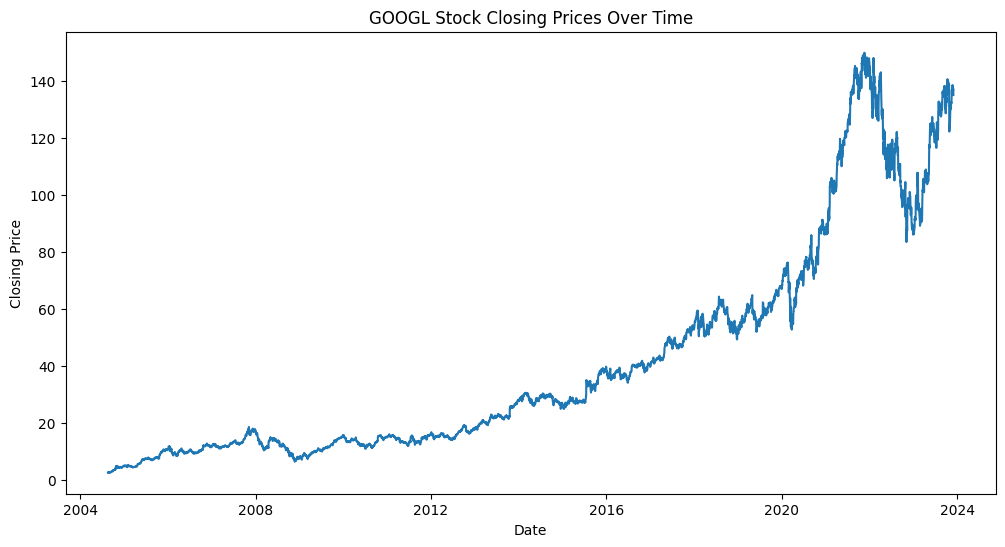

In [28]:
# Ploting closing prices over time
plt.figure(figsize=(12, 6))
plt.plot(stock_data['Close'])
plt.title('GOOGL Stock Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

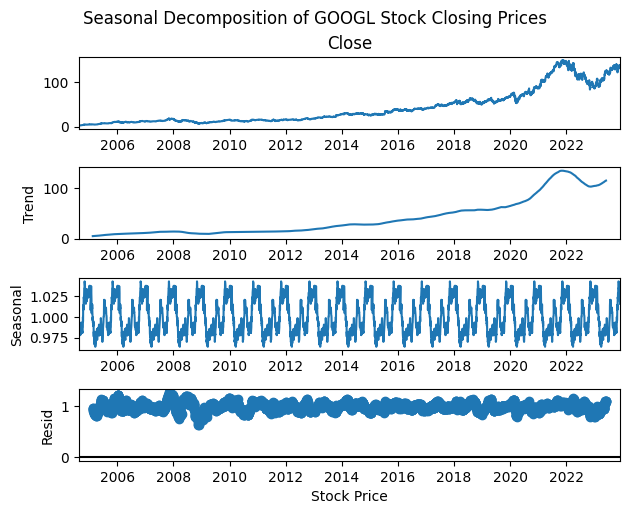

In [32]:
# Analyzing seasonality using seasonal decomposition
result = seasonal_decompose(stock_data['Close'], model='multiplicative', period=252)  # Assuming daily data with 252 trading days in a year
result.plot()
plt.suptitle('Seasonal Decomposition of GOOGL Stock Closing Prices', y=1.02)
plt.xlabel('Stock Price')
plt.show()

In [33]:
# Analyzing volatility (Calculating daily returns)
stock_data['Daily_Return'] = stock_data['Close'].pct_change()
volatility = stock_data['Daily_Return'].std()
print(f"Volatility (standard deviation of daily returns): {volatility}")

Volatility (standard deviation of daily returns): 0.019362421333157777


In [34]:
# Analyzing stationarity using Augmented Dickey-Fuller test
result_adf = adfuller(stock_data['Close'])
print(f'ADF Statistic: {result_adf[0]}')
print(f'p-value: {result_adf[1]}')
print(f'Critical Values: {result_adf[4]}')

ADF Statistic: 0.9270223613321676
p-value: 0.9934330340659407
Critical Values: {'1%': -3.4317068611664014, '5%': -2.8621395810412533, '10%': -2.567089158552129}


### Data Preprocessing

In [5]:
# Extracting the closing stock prices
data = stock_data['Close'].values.reshape(-1, 1)

In [6]:
# Normalizing the data using MinMax Scaler
# The code snippet employs the MinMaxScaler to normalize stock price data, transforming it into a standardized range typically between 0 and 1. Normalization is essential for machine learning models, particularly neural networks, as it ensures that all features share similar scales, preventing biases due to varying magnitudes. 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split the data into training and testing sets
# Following normalization, the data is partitioned into training and testing sets, with 80% of the data allocated for training and the remaining 20% for testing. This division facilitates the evaluation of model performance on unseen data, with the training set used to train the model and the testing set employed to assess its ability to generalize to new, unseen data points.
train_size = int(len(scaled_data) * 0.80)
train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]
print(train_data.shape)
print(test_data.shape)

(3883, 1)
(971, 1)


In [7]:
# The provided code defines a function to create sequences from a given dataset, where each input sequence is a subset of historical data, and the corresponding output is the subsequent data point. This function facilitates the preparation of input-output pairs for training and testing machine learning models, particularly relevant for time series data such as stock prices. In the given example, sequences are generated from normalized training and testing datasets, each containing a sequence length of 10 data points. The resulting sequences are structured to capture historical patterns, aiding in the training of models for predictive tasks on sequential data.
# The code defines a sequence creation function for training and testing sets, extracting input sequences and corresponding output values with a specified length. It is particularly useful for preparing sequential data.

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        seq_in = data[i:i+seq_length, 0]
        seq_out = data[i+seq_length, 0]
        X.append(seq_in)
        y.append(seq_out)
    return np.array(X), np.array(y)

# Set sequence length
seq_length = 10

# Create sequences for training
X_train, y_train = create_sequences(train_data, seq_length)

# Create sequences for testing
X_test, y_test = create_sequences(test_data, seq_length)


### Model Definition

In [8]:
# The code defines a Sequential model with a stacked architecture for stock price prediction using Keras. It comprises four Long Short-Term Memory (LSTM) layers, each containing 50 units, and interspersed with Dropout layers set at a 0.1 dropout rate to mitigate overfitting. The LSTM layers are configured to return sequences where applicable. The final layer is a Dense layer with a single unit for output. This architecture is commonly employed in time series forecasting, where the LSTM layers enable capturing temporal dependencies in sequential data, and the dropout layers aid in preventing overfitting during the training process.

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.1))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=50))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

### Model Training (Epochs 12)

In [9]:
# Training the model 
model.fit(X_train, y_train, epochs=12, batch_size=32)

Epoch 1/12


122/122 [==============================] - 13s 29ms/step - loss: 0.0026
Epoch 2/12
122/122 [==============================] - 3s 26ms/step - loss: 2.5744e-04
Epoch 3/12
122/122 [==============================] - 4s 30ms/step - loss: 2.2343e-04
Epoch 4/12
122/122 [==============================] - 3s 27ms/step - loss: 2.1583e-04
Epoch 5/12
122/122 [==============================] - 3s 28ms/step - loss: 2.0997e-04
Epoch 6/12
122/122 [==============================] - 3s 28ms/step - loss: 2.1500e-04
Epoch 7/12
122/122 [==============================] - 3s 24ms/step - loss: 1.8782e-04
Epoch 8/12
122/122 [==============================] - 3s 23ms/step - loss: 3.0470e-04
Epoch 9/12
122/122 [==============================] - 3s 22ms/step - loss: 1.6664e-04
Epoch 10/12
122/122 [==============================] - 3s 21ms/step - loss: 1.8766e-04
Epoch 11/12
122/122 [==============================] - 3s 24ms/step - loss: 2.1417e-04
Epoch 12/12
122/122 [==============================] - 4s 32ms/ste

### Model Prediction (Epochs 12)

In [10]:
# Generating predictions for the test set
predictions = model.predict(X_test)

# Inverting the scaling for better visualization
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

31/31 [==============================] - 3s 11ms/step


### Model Evaluation (Epochs 12)

In [11]:
# Evaluating
rmse = np.sqrt(np.mean(np.square(predictions - y_test)))
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 6.519666176839698


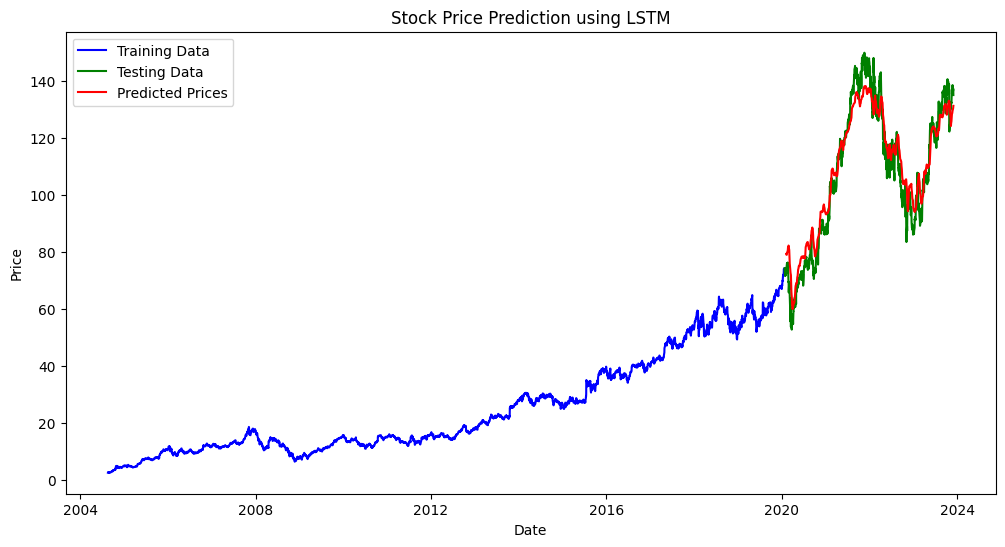

In [12]:
# Ploting
plt.figure(figsize=(12, 6))

# Training data
plt.plot(stock_data.index[:len(train_data)], scaler.inverse_transform(train_data), label='Training Data', color='blue')

# Testing data
plt.plot(stock_data.index[len(train_data):len(train_data) + len(test_data)], scaler.inverse_transform(test_data), label='Testing Data', color='green')

# Predicted prices
plt.plot(stock_data.index[len(train_data) + seq_length:], predictions, label='Predicted Prices', color='red')

plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


### Model Training (Epochs 25)

In [13]:
# Training the model
model.fit(X_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
  5/122 [>.............................] - ETA: 4s - loss: 5.3831e-04

122/122 [==============================] - 4s 29ms/step - loss: 1.8534e-04
Epoch 2/25
122/122 [==============================] - 4s 31ms/step - loss: 1.4740e-04
Epoch 3/25
122/122 [==============================] - 3s 28ms/step - loss: 1.4317e-04
Epoch 4/25
122/122 [==============================] - 3s 27ms/step - loss: 1.4278e-04
Epoch 5/25
122/122 [==============================] - 4s 30ms/step - loss: 1.5492e-04
Epoch 6/25
122/122 [==============================] - 4s 30ms/step - loss: 1.5473e-04
Epoch 7/25
122/122 [==============================] - 4s 30ms/step - loss: 1.5119e-04
Epoch 8/25
122/122 [==============================] - 3s 29ms/step - loss: 1.3201e-04
Epoch 9/25
122/122 [==============================] - 3s 26ms/step - loss: 1.3834e-04
Epoch 10/25
122/122 [==============================] - 4s 31ms/step - loss: 1.3734e-04
Epoch 11/25
122/122 [==============================] - 3s 26ms/step - loss: 1.2443e-04
Epoch 12/25
122/122 [==============================] - 4s 29ms/

### Model Prediction (Epochs 25)

In [14]:
# Generating predictions for the test set
predictions = model.predict(X_test)

# Inverting the scaling for better visualization
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

31/31 [==============================] - 0s 11ms/step


### Model Evaluation (Epochs 25)

In [15]:
# Evaluating
rmse = np.sqrt(np.mean(np.square(predictions - y_test)))
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 16251.556601706481


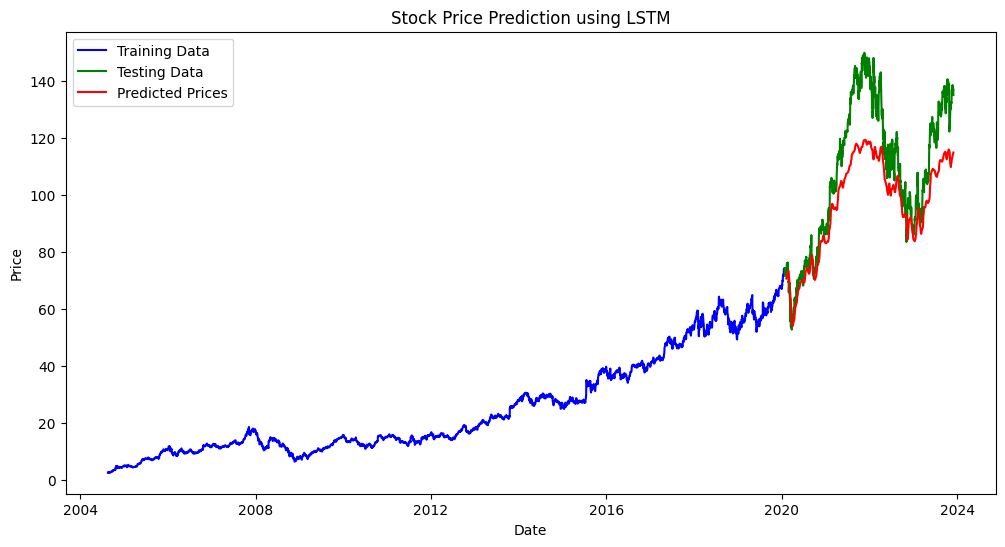

In [16]:
# Ploting
plt.figure(figsize=(12, 6))

# Training data
plt.plot(stock_data.index[:len(train_data)], scaler.inverse_transform(train_data), label='Training Data', color='blue')

# Testing data
plt.plot(stock_data.index[len(train_data):len(train_data) + len(test_data)], scaler.inverse_transform(test_data), label='Testing Data', color='green')

# Predicted prices
plt.plot(stock_data.index[len(train_data) + seq_length:], predictions, label='Predicted Prices', color='red')

plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


### Model Training (Epochs 50)

In [18]:
# Training the model
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
122/122 [==============================] - 3s 28ms/step - loss: 1.0833e-04
Epoch 2/50
122/122 [==============================] - 3s 24ms/step - loss: 1.0230e-04
Epoch 3/50
122/122 [==============================] - 3s 23ms/step - loss: 1.1741e-04
Epoch 4/50
122/122 [==============================] - 3s 26ms/step - loss: 1.0863e-04
Epoch 5/50
122/122 [==============================] - 3s 27ms/step - loss: 1.0860e-04
Epoch 6/50
122/122 [==============================] - 3s 28ms/step - loss: 1.4303e-04
Epoch 7/50
122/122 [==============================] - 3s 24ms/step - loss: 1.0332e-04
Epoch 8/50
122/122 [==============================] - 4s 31ms/step - loss: 1.2072e-04
Epoch 9/50
122/122 [==============================] - 3s 28ms/step - loss: 1.0468e-04
Epoch 10/50
122/122 [==============================] - 3s 27ms/step - loss: 1.0211e-04
Epoch 11/50
122/122 [==============================] - 4s 32ms/step - loss: 1.0313e-04
Epoch 12/50
122/122 [==============================]

### Model Prediction (Epochs 50)

In [19]:
# Generating predictions for the test set
predictions = model.predict(X_test)

# Inverting the scaling for better visualization
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

31/31 [==============================] - 0s 10ms/step


### Model Evaluation (Epochs 50)

In [20]:
# Evaluating
rmse = np.sqrt(np.mean(np.square(predictions - y_test)))
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 2408766.7094417783


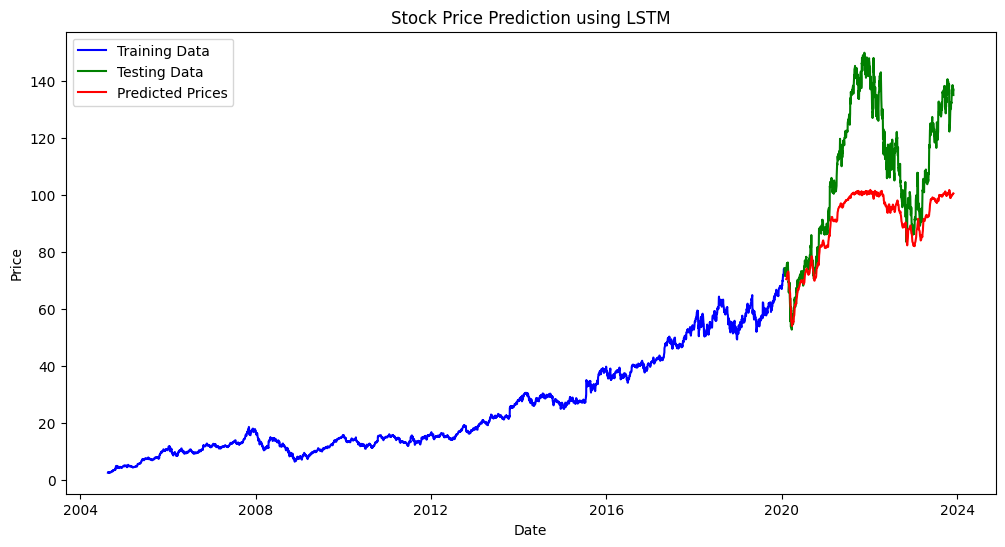

In [21]:
# Ploting
plt.figure(figsize=(12, 6))

# Training data
plt.plot(stock_data.index[:len(train_data)], scaler.inverse_transform(train_data), label='Training Data', color='blue')

# Testing data
plt.plot(stock_data.index[len(train_data):len(train_data) + len(test_data)], scaler.inverse_transform(test_data), label='Testing Data', color='green')

# Predicted prices
plt.plot(stock_data.index[len(train_data) + seq_length:], predictions, label='Predicted Prices', color='red')

plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


### Model Training (Epochs 100)

In [23]:
# Training the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
122/122 [==============================] - 12s 28ms/step - loss: 0.0029
Epoch 2/100
122/122 [==============================] - 3s 25ms/step - loss: 2.7554e-04
Epoch 3/100
122/122 [==============================] - 3s 23ms/step - loss: 2.5706e-04
Epoch 4/100
122/122 [==============================] - 3s 24ms/step - loss: 2.1354e-04
Epoch 5/100
122/122 [==============================] - 3s 25ms/step - loss: 2.2120e-04
Epoch 6/100
122/122 [==============================] - 3s 24ms/step - loss: 2.6752e-04
Epoch 7/100
122/122 [==============================] - 3s 25ms/step - loss: 1.8327e-04
Epoch 8/100
122/122 [==============================] - 3s 25ms/step - loss: 1.6190e-04
Epoch 9/100
122/122 [==============================] - 3s 24ms/step - loss: 1.6278e-04
Epoch 10/100
122/122 [==============================] - 3s 26ms/step - loss: 1.6910e-04
Epoch 11/100
122/122 [==============================] - 3s 24ms/step - loss: 1.8425e-04
Epoch 12/100
122/122 [======================

### Mode Prediction (Epochs 100)

In [24]:
# Generating predictions for the test set
predictions = model.predict(X_test)

# Inverting the scaling for better visualization
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

31/31 [==============================] - 2s 7ms/step


### Model Evaluation (Epochs 100)

In [25]:
# Evaluating
rmse = np.sqrt(np.mean(np.square(predictions - y_test)))
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 354910596.65334445


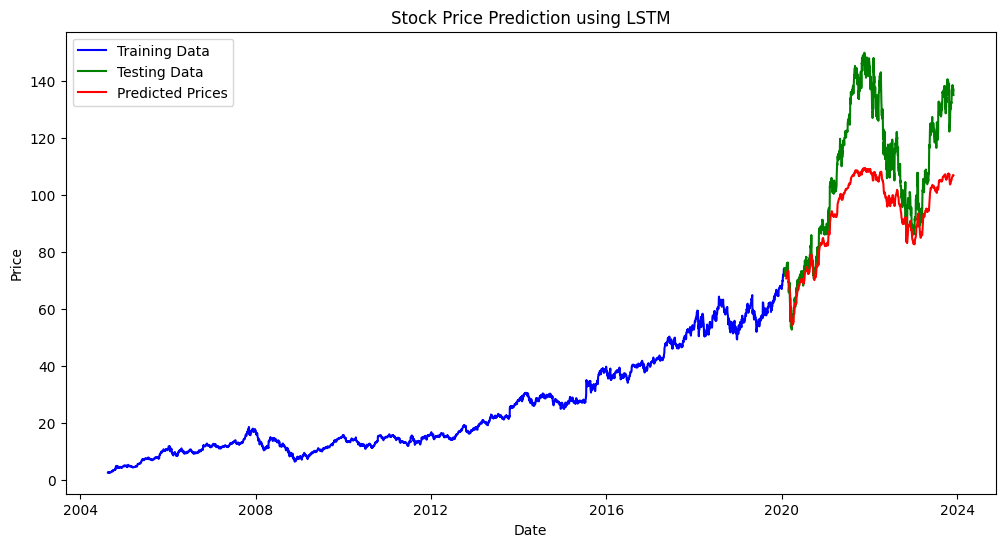

In [26]:
# Ploting
plt.figure(figsize=(12, 6))

# Training data
plt.plot(stock_data.index[:len(train_data)], scaler.inverse_transform(train_data), label='Training Data', color='blue')

# Testing data
plt.plot(stock_data.index[len(train_data):len(train_data) + len(test_data)], scaler.inverse_transform(test_data), label='Testing Data', color='green')

# Predicted prices
plt.plot(stock_data.index[len(train_data) + seq_length:], predictions, label='Predicted Prices', color='red')

plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
